# Using tf.data for finer control

## Imports

In [1]:
%config IPCompleter.use_jedi=False
import os
import tensorflow as tf
import tensorflow
from tensorflow import keras
import numpy as np
import pathlib
from functools import partial
import pandas as pd
import time
from platform import python_version
from datetime import datetime
print("python_version: ", python_version())
print("TensorFlow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))
from glob import glob
%matplotlib inline


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score



# from albumentations import (
#     Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
#     Rotate
# )


import albumentations as A


import matplotlib.pyplot as plt

python_version:  3.8.10
TensorFlow version: 2.4.0
Keras version: 2.4.0


In [2]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

In [3]:
# # specifically working for dgx not on local
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

In [4]:
def print_layers_state(model):
    layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
    layer_df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])
    return layer_df

In [5]:
def cardinality_check(ds):
    num = tf.data.experimental.cardinality(ds).numpy()
    print(num)
    return num

In [6]:
def set_tensorflow_config(per_process_gpu_memory_fraction=0.7):
    config = tf.compat.v1.ConfigProto()
    # config = tf.ConfigProto()
    # config.gpu_options.per_process_gpu_memory_fraction = per_process_gpu_memory_fraction
    config.gpu_options.allow_growth=True
    # sess = tf.Session(config=config)
    sess = tf.compat.v1.Session(config=config)
    print("== TensorFlow Config options set ==")
    print("\nThis process will now utilize {} GPU Memeory Fraction".format(per_process_gpu_memory_fraction))

In [7]:
def split_dataset(dataset, validation_size=0.3, test_size=0.1):
    ## return train, validation and test datasets
    image_count = dataset.cardinality().numpy()
    val_size = int(image_count*validation_size)
    test_size = int(image_count*test_size)
    validation_dataset = dataset.take(val_size)
    dataset = dataset.skip(val_size)
    test_dataset = dataset.take(test_size)
    train_dataset = dataset.skip(test_size)
    
    return train_dataset, validation_dataset, test_dataset

In [8]:
set_tensorflow_config()

== TensorFlow Config options set ==

This process will now utilize 0.7 GPU Memeory Fraction


## Dataset path

In [9]:
abs_dataset_path = '/home/ubuntu/mount/Notebooks/abg/anuj_ws/image-datasets/cats_vs_dogs_redux/original/train/'

In [10]:
data_dir = pathlib.Path(abs_dataset_path)

## get image count

In [11]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

25000


## class names and number

In [12]:
# tf way 
# class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))

# simple way?
CLASS_NAMES =  sorted(os.listdir(data_dir))
print("class names: ", CLASS_NAMES)

NUM_CLASSES = len(CLASS_NAMES)
print("# classes: ", NUM_CLASSES)

class names:  ['cats', 'dogs']
# classes:  2


## list files

In [13]:
list_ds_files = tf.data.Dataset.list_files(str(data_dir)+'/*/*', shuffle=False)
# list_ds = list_ds_files.interleave(lambda x: list_ds_files, cycle_length=4)
list_ds = list_ds_files.shuffle(image_count, reshuffle_each_iteration=False)

In [14]:
cardinality_check(list_ds)

25000


25000

In [15]:
train_ds, validation_ds, test_ds = split_dataset(dataset=list_ds)

In [16]:
NUM_TRAIN_FILES = cardinality_check(train_ds)
NUM_VALIDATION_FILES = cardinality_check(validation_ds)
NUM_TEST_FILES = cardinality_check(test_ds)

15000
7500
2500


In [17]:
def view_image(ds, view_albumentations=False):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(22, 22))
    for i in range(10):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        if view_albumentations:
            ax.imshow(image[i])
        else:
            ax.imshow(image[i].astype(np.uint8))
        ax.set_title(f"Label: {label[i]}")

# Common

In [18]:
BATCH_SIZE = 64
EPOCHS = 50
TL_LEARNING_RATE = 0.001
FT_LEARNING_RATE = 0.00001
DROPOUT_RATE = 0.4
SHUFFLE_BUFFER_SIZE = 1000

TRAIN_STEP_PER_EPOCHS = NUM_TRAIN_FILES/BATCH_SIZE
VALIDATION_STEPS_PER_EPOCHS = NUM_VALIDATION_FILES/BATCH_SIZE
TEST_STEPS_PER_EPOCHS = NUM_TEST_FILES/BATCH_SIZE

DATA_BUFFER_SIZE = 20000
AUTOTUNE = tf.data.experimental.AUTOTUNE
EXPERIMENT_NAME = 'cats_vs_dogs_model'

ONE_HOT = True
IMG_SIZE = 299

INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [19]:
print("step size for training: ", TRAIN_STEP_PER_EPOCHS)
print("step size for validation: ", VALIDATION_STEPS_PER_EPOCHS)
print("step size for test: ", TEST_STEPS_PER_EPOCHS)

step size for training:  234.375
step size for validation:  117.1875
step size for test:  39.0625


In [20]:
def get_label(is_one_hot, CLASS_NAMES, NUM_CLASSES, file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    bool_label = parts[-2] == CLASS_NAMES
    # Integer encode the label
    int_label = tf.argmax(tf.cast(bool_label, tf.int32))
    # return either one hot or sparse label set
    if is_one_hot:
        one_hot_label = tf.one_hot(int_label, NUM_CLASSES)
        return one_hot_label
    else:
        return int_label

## With augmentations

In [21]:
# Instantiate augments
# we can apply as many augments we want and adjust the values accordingly
# here I have chosen the augments and their arguments at random
# transforms = Compose([
#             Rotate(limit=40),
#             RandomBrightness(limit=0.1),
#             JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             RandomContrast(limit=0.2, p=0.5),
#             HorizontalFlip(),
#         ])

In [22]:
transforms = A.Compose([
    #A.Blur(blur_limit=3), # done
#     A.ChannelDropout(),
    A.ChannelShuffle(),
#     A.CLAHE(),
#     #A.CoarseDropout(),
#     A.ColorJitter(),
#     A.RandomContrast()
#     A.Flip(),
#     #A.Cutout(),
#     #A.Equalize(),
    #A.FancyPCA(),
    #A.GaussianBlur(),
#     A.GaussNoise(),
#     #A.GlassBlur(),
    A.HorizontalFlip(),
#     A.Rotate(limit=30),
#     A.Perspective(),
#     A.Sharpen(),
#     #A.ISONoise(),
    #A.MotionBlur(),
#     A.MultiplicativeNoise(),
#     A.RandomBrightnessContrast(),
#     #A.RandomFog(),
#     #A.RandomRain(),
#     #A.RandomShadow(),
#     #A.RandomSnow(),
#     #A.RandomSunFlare(),
#     #A.RandomToneCurve(),
    # A.RandomRotate90(),
#     # A.Transpose(),
#     A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.25),
    
#     A.OpticalDistortion(),
#     A.GridDistortion(),
#     #A.HueSaturationValue(),
])


In [23]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    # not doing cast here because I use preprocess_function
    # from the model chosen. This also changes the view_image function
    # aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

In [24]:
def process_aug_image(image, img_size, aug_fn):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img

In [25]:
def process_with_aug(is_one_hot, CLASS_NAMES, NUM_CLASSES, IMG_SIZE, preprocess_input, aug_fn, file_path):
    label = get_label(is_one_hot, CLASS_NAMES, NUM_CLASSES, file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = process_aug_image(img, IMG_SIZE, aug_fn)
    img = preprocess_input(img)
    return img, label

In [26]:
# def set_shapes(img, label, img_shape=(IMG_SIZE, IMG_SIZE, 3)):
#     img.set_shape(img_shape)
#     label.set_shape([2])
#     return img, label

In [27]:
def set_shapes(image_size, num_classes, img, label):
    img_shape=(image_size, image_size, 3)
    img.set_shape(img_shape)
    label.set_shape([num_classes])
    return img, label

In [28]:
# train_ds = train_ds.map(partial(process_with_aug, ONE_HOT, CLASS_NAMES, 
#                                 NUM_CLASSES, IMG_SIZE, preprocess_input, aug_fn))

In [29]:
# train_ds

In [30]:
# train_ds = train_ds.map(partial(set_shapes, IMG_SIZE, NUM_CLASSES))

In [31]:
# train_ds

In [32]:
# view_image(train_ds.batch(32), view_albumentations=True)

In [33]:
# img = list(train_ds.take(1))

In [34]:
# plt.imshow(img[0][0].numpy().astype('uint8'))
# plt.imshow(img[0][0])

In [35]:
# img

## Without augmentation

In [36]:
def process_without_aug(is_one_hot, CLASS_NAMES, NUM_CLASSES, IMG_SIZE, preprocess_input, file_path):
    label = get_label(is_one_hot, CLASS_NAMES, NUM_CLASSES, file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = preprocess_input(img)
    return img, label

In [37]:
# train_ds = train_ds.map(partial(process_without_aug, ONE_HOT, 
#                                 CLASS_NAMES, NUM_CLASSES, IMG_SIZE, preprocess_input))

In [38]:
# view_image(train_ds.batch(32), view_albumentations=False)

In [39]:
# img = list(train_ds.take(1))

In [40]:
# plt.imshow(img[0][0].numpy().astype('uint8'))

In [41]:
# img

In [42]:
# Configure for performance
def configure_for_performance(ds, ds_type, cache_file_name=None, 
                              batch_size=32, buffer_size=1000, AUTOTUNE=AUTOTUNE):
    # use only when the dataset is small
    if cache_file_name is not None:
        ds = ds.cache(cache_file_name)
    if ds_type == "train":
        print("=== WARNING! train flag supplied")
        ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [43]:

train_ds = train_ds.map(partial(process_with_aug, 
                                ONE_HOT, 
                                CLASS_NAMES, 
                                NUM_CLASSES, 
                                IMG_SIZE, 
                                preprocess_input, aug_fn), num_parallel_calls=AUTOTUNE)

In [45]:
# train_ds = train_ds.map(set_shapes)

In [46]:
train_ds = train_ds.map(partial(set_shapes, IMG_SIZE, NUM_CLASSES))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

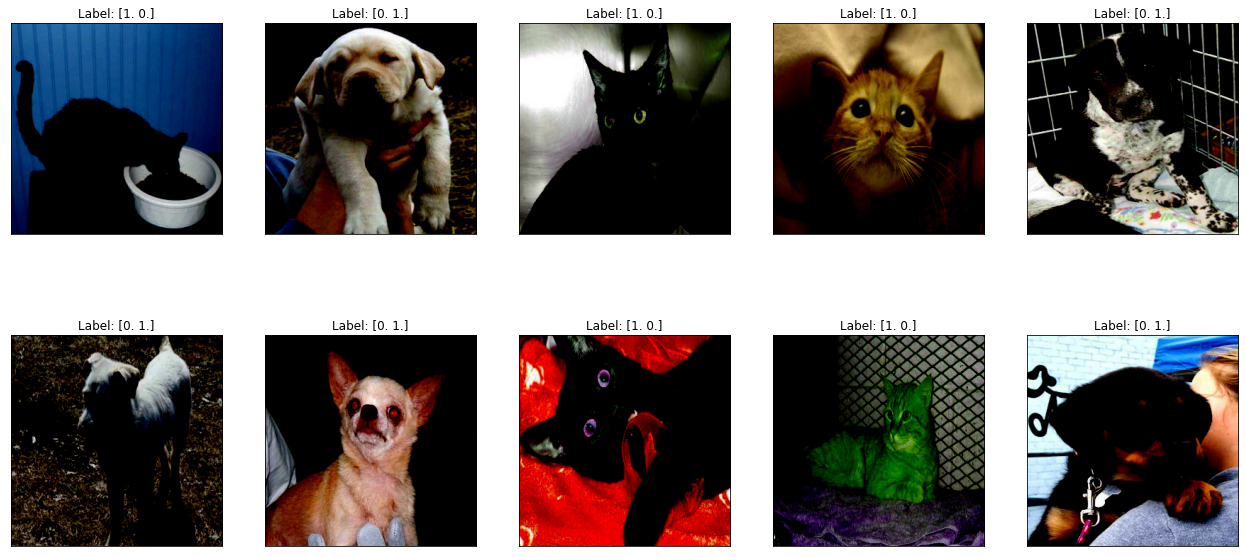

In [47]:
view_image(train_ds.batch(32), view_albumentations=True)

In [ ]:
validation_ds = validation_ds.map(partial(process_without_aug, ONE_HOT, CLASS_NAMES, NUM_CLASSES, IMG_SIZE, preprocess_input), num_parallel_calls=AUTOTUNE)

In [ ]:
test_ds = test_ds.map(partial(process_without_aug, ONE_HOT, CLASS_NAMES, NUM_CLASSES, IMG_SIZE, preprocess_input), num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds, validation_ds, test_ds

In [ ]:
train_ds = configure_for_performance(train_ds, ds_type="train", cache_file_name=None, batch_size=BATCH_SIZE)
train_ds = train_ds.repeat(EPOCHS)

In [ ]:
validation_ds = configure_for_performance(validation_ds, ds_type="", cache_file_name=None, batch_size=BATCH_SIZE)

In [ ]:
test_ds = configure_for_performance(test_ds, ds_type="", cache_file_name=None, batch_size=BATCH_SIZE)

In [ ]:
train_ds, validation_ds, test_ds

In [ ]:
cardinality_check(train_ds)

In [ ]:
base_model = Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=INPUT_SHAPE,
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

In [ ]:
# Create new model on top
inputs = keras.Input(shape=INPUT_SHAPE)
# x = data_augmentation(inputs)  # Apply random data augmentation

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
# x = base_model(x, training=False)
# x = preprocess_input(inputs)
x = base_model(inputs, training=False)
# from here till the classifier layer, it is all experimental 
# as to how many layers we think would be required that can help build a better model for our dataset

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
x = keras.layers.Dense(1024, activation='relu',name='fc-1')(x)
# x = keras.layers.Dropout(0.2)(x)
#x = keras.layers.Dense(256, activation='relu',name='fc-2')(x)
#x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

In [ ]:
print_layers_state(model)

In [ ]:
optimizer = tensorflow.keras.optimizers.Adam()
model.compile(loss=[tf.keras.losses.CategoricalCrossentropy()], optimizer=optimizer, metrics=[ 
                                                                                              tf.keras.metrics.CategoricalAccuracy(),
                                                                                              tf.keras.metrics.AUC(),
                                                                                            ])

In [ ]:
def model_checkpoint(base_checkpoint_name, checkpoint_dir=EXPERIMENT_NAME):
    # Include the epoch in the file name (uses `str.format`)
    checkpoint_filename = '%s_%s.epoch={epoch:02d}-val_acc={val_categorical_accuracy:.2f}.h5'%(datetime.now().strftime("%d_%m_%Y_%H_%M_%S"), base_checkpoint_name)

    # dated_checkpoint_filename = format(datetime.now().strftime("%d_%m_%Y_%H_%M_%S"))
    checkpoint_dir = EXPERIMENT_NAME
    abs_checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)

    # Create a callback that saves the complete model or it's weights every epoch
    # based on the metric being monitored
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                        filepath=abs_checkpoint_path, 
                                                        monitor='val_categorical_accuracy', 
                                                        verbose=1,
                                                        save_freq='epoch',
                                                        save_best_only=True, 
                                                        save_weights_only=False, 
                                                        mode='max')
    return model_checkpoint_callback

In [ ]:
model_checkpoint_callback = model_checkpoint(base_checkpoint_name='TL_MODEL')
early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto'),
reduceLR_callback = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, mode='auto')
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir='./cat_dog_logs')

In [ ]:
start_time= time.perf_counter()

history = model.fit(
            train_ds,
            steps_per_epoch = TRAIN_STEP_PER_EPOCHS,
            validation_data = validation_ds,
            validation_steps = VALIDATION_STEPS_PER_EPOCHS,
            callbacks=[model_checkpoint_callback,
                       early_stopping_callback,
                       reduceLR_callback,
                       tensorboard_callback
                      ],
            epochs=EPOCHS
)

end_time = time.perf_counter()

In [ ]:
model.save('cat_dog_best.h5')

In [ ]:
# model = tf.keras.models.load_model('cats_vs_dogs_model/21_08_2021_08_24_31_TL_MODEL.epoch=05-val_acc=1.00.h5', compile=False)

In [ ]:
base_model.trainable = True

In [ ]:
print_layers_state(model)

In [ ]:
FT_EPOCHS = 100

In [ ]:
ft_model_checkpoint_callback = model_checkpoint(base_checkpoint_name='FT_MODEL')
ft_early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto'),
# reduceLR_callback = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')
ft_tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir='./cat_dog_logs_ft')

In [ ]:
ft_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss=[tf.keras.losses.CategoricalCrossentropy()], optimizer=ft_optimizer, metrics=[tf.keras.metrics.CategoricalCrossentropy(), 
                                                                                              tf.keras.metrics.CategoricalAccuracy(),
                                                                                              # tf.keras.metrics.AUC(),
                                                                                            ])

In [ ]:
start_time= time.perf_counter()

history = model.fit(
            train_ds,
            steps_per_epoch = TRAIN_STEP_PER_EPOCHS,
            validation_data = validation_ds,
            validation_steps = VALIDATION_STEPS_PER_EPOCHS,
            callbacks=[ft_model_checkpoint_callback,
                       ft_early_stopping_callback,
                       ft_tensorboard_callback
                      ],
            epochs=FT_EPOCHS
)

end_time = time.perf_counter()

### Predictions

In [ ]:
predictions = model.predict(test_ds, steps=TEST_STEPS_PER_EPOCHS, verbose=1)

In [ ]:
predictions

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
predicted_classes

In [ ]:
predicted_classes.shape

In [ ]:
# a = list(test_ds.as_numpy_iterator())

In [ ]:
a = test_ds.unbatch().as_numpy_iterator()

In [ ]:
b = list(a)

In [ ]:
im, la = map(list, zip(*b))

In [ ]:
gt_labels = np.stack(la)

In [ ]:
gt_labels.shape

In [ ]:
true_classes = np.argmax(gt_labels, axis=1)

In [ ]:
true_classes.shape

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES)

In [ ]:
print(report)

## Model prediction on test data without labels

In [ ]:
evaluation_test_data_dir = '../image-datasets/cats_vs_dogs_redux/original/test/'

In [ ]:
eval_test_files = tf.data.Dataset.list_files(str(evaluation_test_data_dir + '*'), shuffle=False)

In [ ]:
num_eval_test_files = len([file for file in glob(str(evaluation_test_data_dir + '*'))])

In [ ]:
for i in eval_test_files.take(2):
    print(i)

In [ ]:
eval_dataset = eval_test_files.map(partial(process_without_aug, ONE_HOT, CLASS_NAMES, NUM_CLASSES, IMG_SIZE, preprocess_input), num_parallel_calls=AUTOTUNE)
# #val_dataset = val_dataset.shuffle(buffer_size=1024 ).batch(batch_size) 
# eval_dataset = eval_dataset.batch(BATCH_SIZE)

In [ ]:
eval_dataset = configure_for_performance(eval_dataset, ds_type="", cache_file_name=None, batch_size=BATCH_SIZE)

In [ ]:
eval_test_predictions = model.predict(eval_dataset,  steps=num_eval_test_files/BATCH_SIZE, verbose=1)

In [ ]:
eval_test_predictions

In [ ]:
eval_test_predictions.shape

In [ ]:
# eval_test_predictions_argmax = np.argmax(eval_test_predictions, axis=1)

In [ ]:
# pd.DataFrame(eval_test_predictions_argmax)[0].value_counts()

In [ ]:
name_list = list(map(lambda x:int(x.decode().split(os.path.sep)[-1].split('.')[0]), list(eval_test_files.as_numpy_iterator())))

In [ ]:
np.array(name_list).shape

In [ ]:
out = list(zip(name_list, list(np.around(eval_test_predictions[:, 1], decimals=4))))

In [ ]:
def last(n):
    return n[0]  
   
def sort(tuples):
    return sorted(tuples, key=last)
   

In [ ]:
sorted_out = sort(out)

In [ ]:
df = pd.DataFrame(sorted_out, columns=["id", "label"])

In [ ]:
df.to_csv('sub_test.csv', index=False)

### Evaluation on test data

## References
1. https://www.tensorflow.org/tutorials/load_data/images
2. Build model without the augmentation layer: https://keras.io/guides/transfer_learning/
3. Using functools partial to provide parameters to tf.data.dataset map function: https://stackoverflow.com/questions/46263963/how-to-map-a-function-with-additional-parameter-using-the-new-dataset-api-in-tf1
4. Keras preprocess_input vs image normalization by 255: https://stackoverflow.com/questions/54702212/keras-rescale-1-255-vs-preprocessing-function-preprocess-input-which-one-to
5. using preprocess input as a part of model layer: https://keras.io/examples/keras_recipes/tfrecord/